In [1]:
import os
import shutil  #for copying files
import random
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import math
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.__version__

'2.13.0'

In [3]:
seed = 1
random.seed(seed)
directory = "data/ISIC_training_images/"
train ="data/train/"
test = "data/test/"
validation ="data/validation/"

In [4]:
os.makedirs(train + "benign/")
os.makedirs(train + "malignant/")
os.makedirs(test + "benign/")
os.makedirs(test + "malignant/")
os.makedirs(validation + "benign/")
os.makedirs(validation + "malignant/")

In [5]:
test_examples = train_examples = validation_examples = 0

for line in open("data/ISIC_labels.csv").readlines()[1:]:
    split_line = line.split(",")
    img_file = split_line[0]
    benign_malign = split_line[1]

    random_num = random.random() #random number between 0 and 1

    if random_num < 0.8:
        location = train
        train_examples += 1

    elif random_num < 0.9:
        location = validation
        validation_examples += 1

    else:
        location = test
        test_examples += 1

    if int(float(benign_malign)) == 0:
        shutil.copy(
            "data/ISIC_training_images/" + img_file + ".jpg",
            location + "benign/" + img_file + ".jpg",
        )

    elif int(float(benign_malign)) == 1:
        shutil.copy(
            "data/ISIC_training_images/" + img_file + ".jpg",
            location + "malignant/" + img_file + ".jpg",
        )

In [6]:
print(f"Number of training examples {train_examples}")
print(f"Number of test examples {test_examples}")
print(f"Number of validation examples {validation_examples}")

Number of training examples 20225
Number of test examples 2555
Number of validation examples 2551


In [7]:
train_examples = 20225
test_examples = 2551
validation_examples = 2555
img_height = img_width = 224
batch_size = 32

In [8]:
#NasNet
model = keras.Sequential([
   hub.KerasLayer("https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
                  trainable=True),
   layers.Dense(1, activation="sigmoid"),
])

In [9]:
train_datagen=ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    zoom_range=(.95,.95),
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last",
    dtype="float32",
)

In [10]:
validation_datagen=ImageDataGenerator(rescale=1.0/255,dtype="float32")
test_datagen=ImageDataGenerator(rescale=1.0/255,dtype="float32")

In [11]:
train_gen=train_datagen.flow_from_directory(
    "data/train/",
    target_size=(img_height,img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)

Found 20225 images belonging to 2 classes.


In [12]:
validation_gen = validation_datagen.flow_from_directory(
    "data/validation/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)

Found 2551 images belonging to 2 classes.


In [13]:
test_gen=test_datagen.flow_from_directory(
    "data/test/",
    target_size=(img_height,img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)

Found 2555 images belonging to 2 classes.


In [14]:
METRICS = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
]

In this block, I defined list of evaluation metrics (METRICS) for the model. These metrics will be used to assess the model's performance during training and evaluation. The metrics include accuracy, precision, recall, and the area under the ROC curve (AUC).

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=[keras.losses.BinaryCrossentropy(from_logits=False)],
    metrics=METRICS,
)

In [16]:
model.fit(
    train_gen,
    epochs=1,
    verbose=2,
    steps_per_epoch=train_examples // batch_size,
    validation_data=validation_gen,
    validation_steps=validation_examples // batch_size,
    callbacks=[keras.callbacks.ModelCheckpoint("isic_model")],
)


INFO:tensorflow:Assets written to: isic_model\assets


INFO:tensorflow:Assets written to: isic_model\assets


632/632 - 4314s - loss: 0.7423 - accuracy: 0.8565 - precision: 0.6771 - recall: 0.3834 - auc: 0.8269 - val_loss: 0.7243 - val_accuracy: 0.8604 - val_precision: 0.9667 - val_recall: 0.1991 - val_auc: 0.8803 - 4314s/epoch - 7s/step


In [17]:
def plot_roc(labels, data):
    predictions = model.predict(data)
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100 * fp, 100 * tp)
    plt.xlabel("False positives [%]")
    plt.ylabel("True positives [%]")
    plt.show()

80/80 [==============================] - 119s 1s/step


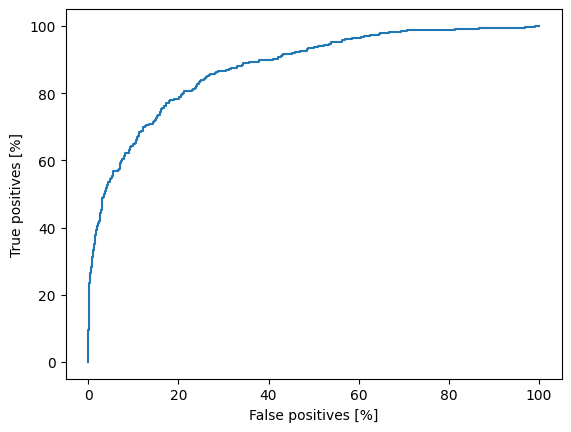

In [18]:
test_labels = np.array([])
num_batches = 0

for _, y in test_gen:
    test_labels = np.append(test_labels, y) # assigning the test labels
    num_batches += 1
    if num_batches == math.ceil(test_examples / batch_size):
        break

plot_roc(test_labels, test_gen)

In [19]:
model.evaluate(validation_gen, verbose=2)
model.evaluate(test_gen, verbose=2)

80/80 - 118s - loss: 0.7241 - accuracy: 0.8604 - precision: 0.9674 - recall: 0.2014 - auc: 0.8806 - 118s/epoch - 1s/step
80/80 - 120s - loss: 0.7384 - accuracy: 0.8579 - precision: 0.9490 - recall: 0.2062 - auc: 0.8768 - 120s/epoch - 1s/step


[0.7383702993392944,
 0.8579256534576416,
 0.9489796161651611,
 0.20620842278003693,
 0.8767583966255188]